# Introduction

In this notebook, we will train a neural network using Tensorflow to classify animal images.

We will be using the Animal data in this notebook
[dataset](https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import tensorflow as tf
import numpy as np
# import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random

# Load the Data

In [5]:
animals_dataset = ["cats","dogs","panda"]

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

batch_size= 16
data_dir = "data/animals/"
img_height = 32
img_width = 55
# Rescaling the input image as well as Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes = animals_dataset,
    subset='training',
    shuffle=True) # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes = animals_dataset,
    subset='validation',
    shuffle=True) # set as validation data

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


# Visualising samples from training set

In [7]:
training_samples, labels = train_generator.next()

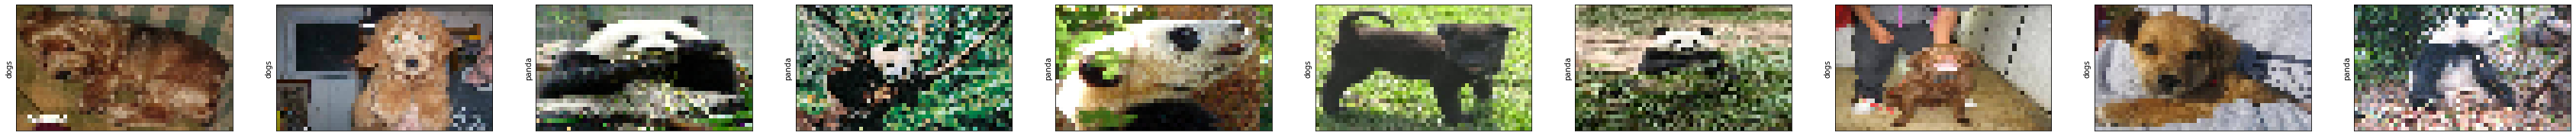

In [8]:
plt.figure(figsize=(60, 60))

for i in range(10):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    image = training_samples[i]
    plt.imshow(image, cmap=plt.cm.binary)
    label = int(np.argmax(labels[i]))
    plt.ylabel(animals_dataset[label])
plt.show()

# The model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import TensorBoard
import datetime

## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Baseline model

In [10]:
baseline_model = Sequential()

baseline_model.add(Convolution2D(32, (2, 2), activation='relu', input_shape=(img_height, img_width, 3)))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
baseline_model.add(Convolution2D(32, (2, 2), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Flatten())
baseline_model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

baseline_model.add(Dense(3, activation='softmax'))

baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(baseline_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 54, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 26, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 13, 32)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2912)              0         
                                                                 
 dense (Dense)               (None, 128)              

Visualising the model

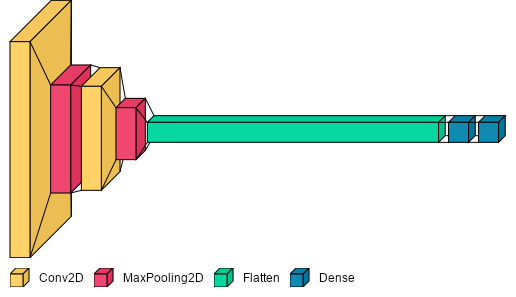

In [18]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 12, encoding="unic")
visualkeras.layered_view(baseline_model, legend=True, font=font)

In [14]:
log_dir_baseline = "logs/fit/animal-classifier-baseline" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_baseline_callback = TensorBoard(log_dir=log_dir_baseline, histogram_freq=1)
callbacks_baseline = [tensorboard_baseline_callback]

baseline_model.fit(train_generator,
          validation_data=validation_generator,
          epochs=50,
          verbose=1,
          callbacks=callbacks_baseline)

Epoch 1/50
150/150 [==============================] - 5s 30ms/step - loss: 1.4365 - accuracy: 0.5279 - val_loss: 0.9342 - val_accuracy: 0.5717
Epoch 2/50
150/150 [==============================] - 4s 29ms/step - loss: 0.8285 - accuracy: 0.6371 - val_loss: 0.8860 - val_accuracy: 0.5733
Epoch 3/50
150/150 [==============================] - 4s 29ms/step - loss: 0.7751 - accuracy: 0.6617 - val_loss: 0.7921 - val_accuracy: 0.6383
Epoch 4/50
150/150 [==============================] - 4s 29ms/step - loss: 0.7158 - accuracy: 0.6942 - val_loss: 0.7777 - val_accuracy: 0.6300
Epoch 5/50
150/150 [==============================] - 4s 29ms/step - loss: 0.7231 - accuracy: 0.6804 - val_loss: 0.7654 - val_accuracy: 0.6600
Epoch 6/50
150/150 [==============================] - 4s 29ms/step - loss: 0.6965 - accuracy: 0.7117 - val_loss: 0.7505 - val_accuracy: 0.6600
Epoch 7/50
150/150 [==============================] - 4s 29ms/step - loss: 0.6679 - accuracy: 0.7271 - val_loss: 0.7967 - val_accuracy: 0.6333

## Optimized Model

In [19]:
model = Sequential()

model.add(Convolution2D(32, (2, 2), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 31, 54, 32)        416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 27, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 26, 32)        4128      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 13, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 13, 32)         0         
                                                                 
 flatten_1 (Flatten)         (None, 2912)             

Visualising the model

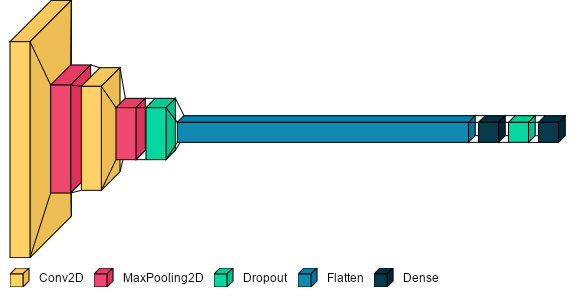

In [20]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 12, encoding="unic")
visualkeras.layered_view(model, legend=True, font=font)

### Training

In [19]:
filepath = 'models/animal-image-classification.h5'
checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1, save_best_only=True,mode='max')

log_dir = "logs/fit/animal-classifier" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [checkpoint, tensorboard_callback]

model.fit(train_generator,
          validation_data=validation_generator,
          epochs=50,
          verbose=1,
          callbacks=callbacks)

Epoch 1/50
149/150 [============================>.] - ETA: 0s - loss: 1.4852 - accuracy: 0.5461
Epoch 1: val_accuracy improved from -inf to 0.59333, saving model to models\animal-image-classification.h5
150/150 [==============================] - 5s 29ms/step - loss: 1.4838 - accuracy: 0.5462 - val_loss: 0.9907 - val_accuracy: 0.5933
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.8864 - accuracy: 0.6379
Epoch 2: val_accuracy improved from 0.59333 to 0.62833, saving model to models\animal-image-classification.h5
150/150 [==============================] - 4s 29ms/step - loss: 0.8864 - accuracy: 0.6379 - val_loss: 0.8359 - val_accuracy: 0.6283
Epoch 3/50
149/150 [============================>.] - ETA: 0s - loss: 0.8091 - accuracy: 0.6581
Epoch 3: val_accuracy did not improve from 0.62833
150/150 [==============================] - 4s 28ms/step - loss: 0.8084 - accuracy: 0.6583 - val_loss: 0.8837 - val_accuracy: 0.6050
Epoch 4/50
148/150 [============================

## Evaluate

In [20]:
loaded_model = tf.keras.models.load_model(filepath)

In [21]:
test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
print("Validation Loss: {}, Validation Accuracy: {}".format(test_loss, test_accuracy))

38/38 [==============================] - 1s 19ms/step - loss: 0.8147 - accuracy: 0.7700
Validation Loss: 0.814729630947113, Validation Accuracy: 0.7699999809265137


# Test the model

In [22]:
from tensorflow.keras import layers

test_ds = tf.keras.utils.image_dataset_from_directory(
    'data\images',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 3 files belonging to 3 classes.


In [23]:
def plot_image(i, predictions_array, true_label, img):
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  color = 'green' if predicted_label == true_label else 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(animals_dataset[predicted_label],
                                100*np.max(predictions_array),
                                animals_dataset[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    plt.xticks(range(3), animals_dataset)
    plt.yticks([])
    thisplot = plt.bar(range(3), predictions_array, color="#7d4646")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

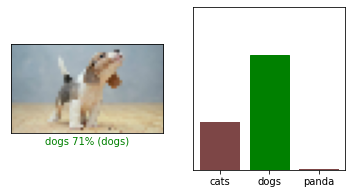

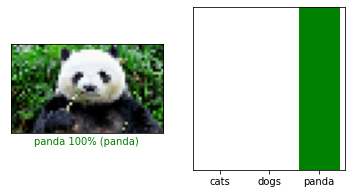

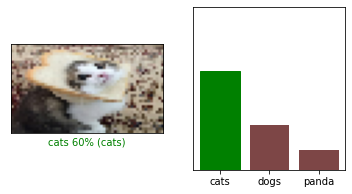

In [24]:
for images, labels in normalized_ds.take(1):
    for i in range(3):
        image = images[i]
        label = labels[i]
        image_batch = tf.expand_dims(image, [0])
        prediction = loaded_model.predict(image_batch)

        # Plotting
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plot_image(i, prediction[0], label, image)
        plt.subplot(1,2,2)
        plot_value_array(i, prediction[0],  label)
        plt.show()